# Customer Churn Project — Part 2: Explonatory Data Analysis

This notebook is the starting point for the Customer Churn Analysis Project. Its primary goals are to ingest, explore, clean, and augment the customer activity logs to build a robust dataset for understanding user behavior and churn.

Specifically, in this notebook, I:
1. Conduct exploratory data analysis (EDA) to compare active vs. churned users across engagement metrics.
2. Examine event distributions, feature correlations, and behavioral indicators leading to churn.
3. Analyze temporal and geographic churn trends to understand how churn varies across months and states.
4. Identify early behavioral signals (e.g., low activity, fewer playlists, short active periods) that differentiate churned users.
5. Prepare analytical insights to inform predictive modeling and feature selection in the next stage (03_Modeling.ipynb).

The focus of this notebook is on uncovering data-driven insights about customer retention and disengagement, laying the foundation for building a churn prediction model and actionable business recommendations.

In [4]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd



sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [5]:
import os
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

try:
    spark.stop()
except:
    pass

# Build Spark
spark = (
    SparkSession.builder
    .appName("CustomerChurn_EDA")
    .master("local[*]")
    .config("spark.driver.memory", "6g")   # use "8g" if you have ≥16 GB RAM
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

### I. Data Loading

In [6]:
data = spark.read.parquet("../data/cleaned_churn_data.parquet")

The dataset contains detailed user activity logs from a digital music streaming service.
Each record represents a user interaction — such as playing a song, giving a thumbs-up, or canceling a subscription — and includes demographic, behavioral, and technical information.
The data spans over different events and covers attributes like user identifiers, session details, song information, access methods, timestamps, and locations.
Additional engineered features (state, city, datetime, month, year) support time- and location-based analysis, while the churn_flag column labels users who have canceled their subscriptions, enabling churn prediction and retention analysis.

In [7]:
data.printSchema()
data.show(5)

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn_flag: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- date: date (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)

+-------+--------------+---------+------

### II. Basic sanity checks

#### 1. Quick Data Check

The dataset includes 22,278 unique users who generated around 228,713 sessions and performed 22 different types of actions within the application.
In total, it contains over 26 million event records, providing a comprehensive view of user behavior and engagement across the platform.

In [8]:
# number of unique users
num_users = data.select("userId").distinct().count()
print(f"Number of unique users: {num_users}")

# number of unique sessions
num_sessions = data.select("sessionId").distinct().count()
print(f"Number of unique sessions: {num_sessions}")

# number of unique events (what users can do in App and with App)
num_unique_events = data.select("page").distinct().count()
print(f"Number of unique events: {num_unique_events}")

# total number of events = rows
num_events = data.count()
print(f"Total number of events (records): {num_events}")

Number of unique users: 22278


Number of unique sessions: 228713


Number of unique events: 22
Total number of events (records): 26259199


In [9]:
data.createOrReplaceTempView("user_data")

In [10]:
spark.sql("""
    SELECT *
    FROM user_data
    WHERE userId == 1994878
""").show(truncate=False)

+-------+----------------------------------------------------------------------+---------+---------+------+-------------+--------+---------+-----+----------------------------+------+----------+-------------+---------+-------------------------------------------------------------------+------+-------------+-----------------------------------------------------------------------------------------------------------------------+----------+-----+------------------------+-------------------+----------+-----+----+
|userId |artist                                                                |auth     |firstName|gender|itemInSession|lastName|length   |level|location                    |method|page      |registration |sessionId|song                                                               |status|ts           |userAgent                                                                                                              |churn_flag|state|city                    |datetime           |d

The chart below shows the distribution of user actions recorded in the dataset.
The “NextSong” event dominates the activity log, indicating that most user interactions involve playing music tracks.
Other common events, such as Home, Thumbs Up, Add to Playlist, and Roll Advert, appear far less frequently.
Less frequent actions — including Cancel, Cancellation Confirmation, and Logout — provide key behavioral signals for identifying users likely to churn.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


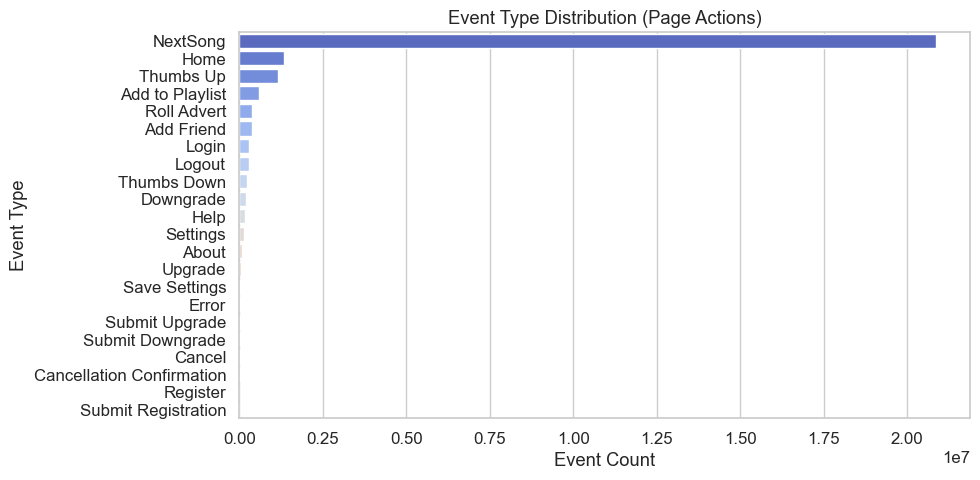

In [28]:
event_counts = (
    data.groupBy("page")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(data=event_counts, x="count", y="page", palette="coolwarm", hue="page", legend=False)
plt.title("Event Type Distribution (Page Actions)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

### II. Missing values overview

The missing value analysis reveals that several columns contain null or empty entries, particularly those related to user demographics and activity details such as artist, firstName, lastName, location, and userAgent. Columns like userId, page, sessionId, and ts are mostly complete, ensuring that key behavioral data remains reliable for downstream analysis.



So far, I can say that missing (NA) `registration` values could be a potential problem.

Variables such as:

`artist`, `song`, and `length` – may be missing for non-music events (e.g., login, logout), which is expected and acceptable;

`firstName`, `lastName`, and `gender` – demographic gaps are common for anonymous or guest users;

`location`, `state`, and `city` – may be missing if userAgent data lacks geolocation information; this is acceptable for most sessions;

`userAgent` – can be null for backend or system-generated events and is not essential for churn modeling.


I will conduct a more detailed analysis of missing values later in this notebook to better understand their patterns, potential causes, and impact on model performance.

In [12]:
data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data.columns]).show(truncate=False)

+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+--------+----+-----+----+
|userId|artist |auth|firstName|gender|itemInSession|lastName|length |level|location|method|page|registration|sessionId|song   |status|ts |userAgent|churn_flag|state |city  |datetime|date|month|year|
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+--------+----+-----+----+
|0     |5408927|0   |778479   |778479|0            |778479  |5408927|0    |778479  |0     |0   |778479      |0        |5408927|0     |0  |778479   |0         |778479|778479|0       |0   |0    |0   |
+------+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+----------+------+------+--------+----+-----+----+



Overall, there are 22 unique user activities:

In [13]:
unique_pages = data.select("page").distinct().toPandas()["page"].unique()
print("Unique page variables ({}):\n{}".format(len(unique_pages), unique_pages))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Unique page variables (22):
['Home' 'Settings' 'Error' 'Submit Upgrade' 'About' 'Cancel' 'NextSong'
 'Thumbs Up' 'Help' 'Logout' 'Submit Downgrade' 'Login'
 'Submit Registration' 'Downgrade' 'Save Settings' 'Register'
 'Add to Playlist' 'Cancellation Confirmation' 'Add Friend' 'Thumbs Down'
 'Roll Advert' 'Upgrade']


In [14]:
spark.sql("""
    SELECT *
    FROM user_data
    WHERE gender IS NULL
""").show(truncate=False)

+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|userId |artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page |registration|sessionId|song|status|ts           |userAgent|churn_flag|state|city|datetime           |date      |month|year|
+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|1261737|NULL  |Logged Out|NULL     |NULL  |200          |NULL    |NULL  |paid |NULL    |GET   |About|NULL        |44007    |NULL|200   |1539108795000|NULL     |0         |NULL |NULL|2018-10-09 11:13:15|2018-10-09|10   |2018|
|1261737|NULL  |Logged Out|NULL     |NULL  |189          |NULL    |NULL  |free |NULL    |GET   |

All user activities where gender (and likely first/last names and location) are NULL:

In [15]:
spark.sql("""
    SELECT distinct page
    FROM user_data
    WHERE gender IS NULL
""").show(truncate=False)

+-------------------+
|page               |
+-------------------+
|About              |
|Home               |
|Error              |
|Login              |
|Help               |
|Submit Registration|
|Register           |
+-------------------+



In [16]:
data.filter(F.col("gender").isNull()).show(truncate=False)

+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|userId |artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page |registration|sessionId|song|status|ts           |userAgent|churn_flag|state|city|datetime           |date      |month|year|
+-------+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+----------+-----+----+-------------------+----------+-----+----+
|1261737|NULL  |Logged Out|NULL     |NULL  |200          |NULL    |NULL  |paid |NULL    |GET   |About|NULL        |44007    |NULL|200   |1539108795000|NULL     |0         |NULL |NULL|2018-10-09 11:13:15|2018-10-09|10   |2018|
|1261737|NULL  |Logged Out|NULL     |NULL  |189          |NULL    |NULL  |free |NULL    |GET   |

A quick check whether my hypothesis is correct:

In [17]:
spark.sql("""
    SELECT userId, page, gender, firstName, lastName, location
    FROM user_data
    WHERE
        (gender IS NULL OR firstName IS NULL OR lastName IS NULL OR location IS NULL)
        AND page NOT IN (
            SELECT DISTINCT page
            FROM user_data
            WHERE gender IS NULL
        )
""").show(truncate=False)

+------+----+------+---------+--------+--------+
|userId|page|gender|firstName|lastName|location|
+------+----+------+---------+--------+--------+
+------+----+------+---------+--------+--------+



All null values in user demographic or location fields occur only on pages (like Login, Register, Cancel, etc.) where missing user data is expected. So my dataset is logically consistent, and I don’t have unexpected missing data in user-related columns.


### III.  Churn Rate Analysis

#### 1. User Behavior after Cancellation

The dataset shows a clear imbalance between active and churned users.
Out of 22,278 unique users, 5,003 (22.5%) have canceled their subscriptions, while 17,275 (77.5%) remain active.
This imbalance is typical in churn datasets and should be considered during model training to ensure that the model doesn’t become biased toward the majority (active) class.

In [18]:
data.select("userId", "churn_flag").distinct().groupBy("churn_flag").count().show()

+----------+-----+
|churn_flag|count|
+----------+-----+
|         1| 5003|
|         0|17275|
+----------+-----+



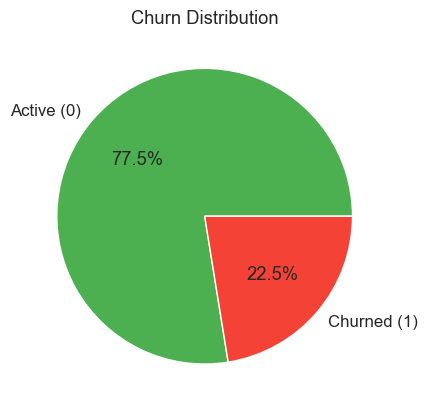

In [19]:
churn_df = data.select("userId", "churn_flag").distinct()
churn_counts = churn_df.groupBy("churn_flag").count().orderBy("churn_flag").toPandas()

plt.pie(
    churn_counts["count"],
    labels=["Active (0)", "Churned (1)"],
    autopct="%1.1f%%",
    colors=["#4CAF50", "#F44336"],
)
plt.title("Churn Distribution")
plt.show()

The most important question is to understand how users who churned behaved after cancellation. Earlier, I defined churned users as those who triggered the “Cancellation Confirmation” event.

Now, I need to verify that these users never used the app again after this event, as they would have effectively lost access to their accounts once the cancellation was completed.

In [20]:
churn_events = spark.sql("""
    SELECT 
        userId,
        MAX(ts) AS cancel_ts
    FROM user_data
    WHERE page = 'Cancellation Confirmation'
    GROUP BY userId
""")
churn_events.createOrReplaceTempView("churn_events")

In [21]:
spark.sql("""
    SELECT 
        u.userId,
        u.page,
        u.ts,
        e.cancel_ts
    FROM user_data u
    JOIN churn_events e
        ON u.userId = e.userId
    WHERE u.ts > e.cancel_ts
    ORDER BY u.userId, u.ts
""").show(truncate=False)

+------+----+---+---------+
|userId|page|ts |cancel_ts|
+------+----+---+---------+
+------+----+---+---------+



The query returned no records, confirming that once users canceled their subscriptions, they no longer interacted with the platform.
Moreover, the dataset does not contain identifiable information such as emails or phone numbers that could confirm if users returned under a different account.
While first and last names are available, they are not reliable for cross-user tracking.

Therefore, we can confidently assume that these users permanently churned, and safely proceed with churn behavior analysis based on this definition.

#### 2. Types of Subscription 


The dataset shows that users of the Music App have two subscription levels: free (with limits) and paid.

In [22]:
spark.sql("""
    SELECT distinct level
    FROM user_data
""").show(truncate=False)

+-----+
|level|
+-----+
|paid |
|free |
+-----+



While both groups show churn, paid users demonstrate slightly better retention — fewer cancellations relative to their total base.
However, a considerable portion of free users also remain active, suggesting that user engagement and conversion strategies may play a stronger role in retention than subscription level alone.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


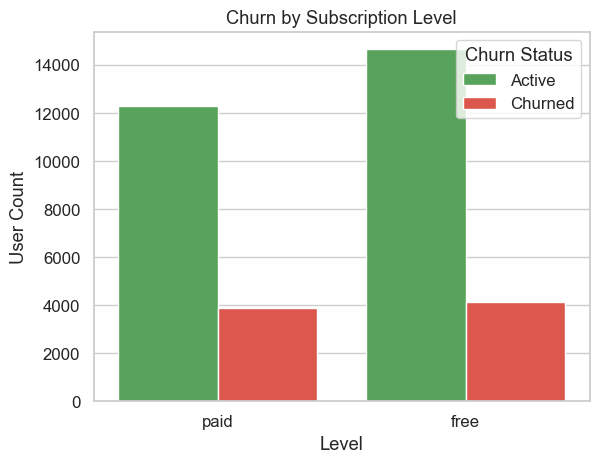

In [29]:
df = data.select("userId", "level", "churn_flag").distinct()
level_churn = df.groupBy("level", "churn_flag").count().toPandas()

ax = sns.barplot(
    data=level_churn, 
    x="level", 
    y="count", 
    hue="churn_flag",
    palette=["#4CAF50", "#F44336"]
)
plt.title("Churn by Subscription Level")
plt.xlabel("Level")
plt.ylabel("User Count")
# Add legend with appropriate labels for clarity
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["Active", "Churned"], title="Churn Status")
plt.show()

### IV. Gender & Level Distribution

#### 1. Does the dataset have more men or more women?

The user base is relatively balanced between genders, with 52.3% male and 47.7% female users among the 22,277 total unique accounts.
This near-even split indicates that both gender groups are well represented in the dataset, allowing for unbiased analysis of engagement and churn patterns across demographic segments.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_86371/963792710.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=gender_counts, x="gender", y="count", palette=["#A7C7E7", "#F4B183"])


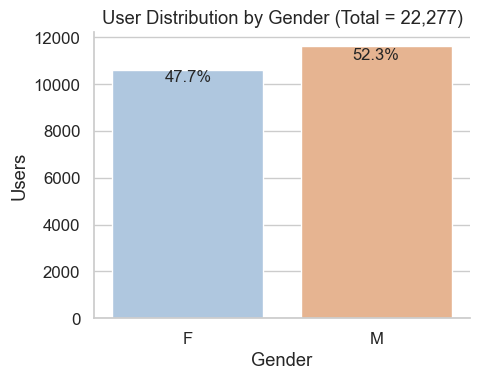

In [30]:
df = data.filter(F.col("gender").isNotNull()).select("userId", "gender").distinct()
gender_counts = df.groupBy("gender").count().toPandas().sort_values("gender")

total = gender_counts["count"].sum()
gender_counts["percent"] = (100 * gender_counts["count"] / total).round(1)

plt.figure(figsize=(5,4))
ax = sns.barplot(data=gender_counts, x="gender", y="count", palette=["#A7C7E7", "#F4B183"])

for i, r in gender_counts.iterrows():
    ax.text(i, r["count"]*0.95, f'{r["percent"]:.1f}%', ha='center', fontsize=12)

plt.title(f"User Distribution by Gender (Total = {total:,})")
plt.xlabel("Gender"); plt.ylabel("Users")
sns.despine(); plt.tight_layout(); plt.show()

#### 2. Who is more likely to churn?

Both male (M) and female (F) users follow a similar pattern — in each group, the majority of users remain active (green), while a smaller portion has churned (red).
The difference between genders is minimal, suggesting that churn behavior does not vary significantly by gender.
In other words, gender alone is unlikely to be a strong predictor of user churn in this dataset.

In [32]:
gender_churn = spark.sql("""
    SELECT gender, churn_flag, count(*)
    FROM user_data
    WHERE gender IS NOT NULL
    GROUP BY gender, churn_flag
    ORDER BY churn_flag
""").show(truncate=False)

+------+----------+--------+
|gender|churn_flag|count(1)|
+------+----------+--------+
|F     |0         |9682839 |
|M     |0         |10415414|
|M     |1         |2884148 |
|F     |1         |2498319 |
+------+----------+--------+



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


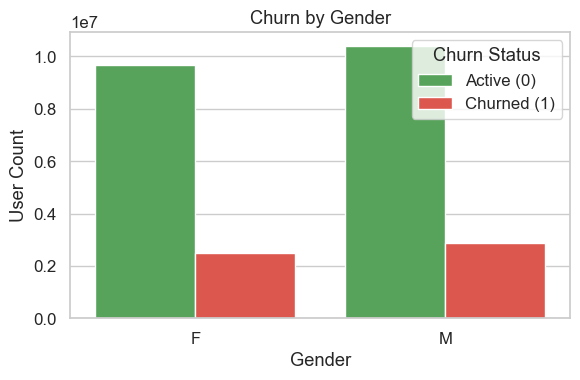

In [36]:
# Convert Spark DataFrame to Pandas for plotting
gender_churn = spark.sql("""
    SELECT gender, churn_flag, COUNT(*) as count
    FROM user_data
    WHERE gender IS NOT NULL
    GROUP BY gender, churn_flag
    ORDER BY gender, churn_flag
""").toPandas()

plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=gender_churn_pd,
    x="gender", y="count",
    hue="churn_flag",
    palette=["#4CAF50", "#F44336"]
)
plt.title("Churn by Gender")
plt.xlabel("Gender"); plt.ylabel("User Count")
legend_labels = ["Active (0)", "Churned (1)"]
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, legend_labels, title="Churn Status")
plt.tight_layout()
plt.show()

#### 3. Who is more likely to have premium subscription?

Most users — both male (M) and female (F) — are on the paid plan, indicating higher engagement or conversion to premium services.
The number of free users is noticeably smaller, and the gender split within each level is quite balanced.
Overall, both men and women participate actively across subscription levels, with slightly more male users overall in both free and paid tiers.

In [37]:
spark.sql("""
    SELECT level, gender, count(*)
    FROM user_data
    WHERE gender IS NOT NULL
    GROUP BY level, gender
""").show(truncate=False)

+-----+------+--------+
|level|gender|count(1)|
+-----+------+--------+
|paid |M     |10482848|
|free |F     |2591526 |
|paid |F     |9589632 |
|free |M     |2816714 |
+-----+------+--------+



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


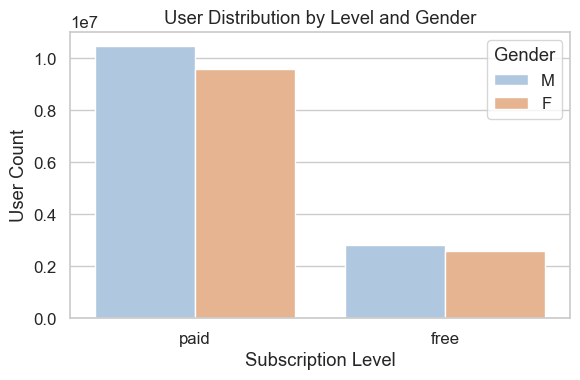

In [38]:
level_gender = spark.sql("""
    SELECT level, gender, COUNT(*) AS count
    FROM user_data
    WHERE gender IS NOT NULL
    GROUP BY level, gender
""").toPandas()

plt.figure(figsize=(6,4))
sns.barplot(data=level_gender, x="level", y="count", hue="gender",
            palette=["#A7C7E7", "#F4B183"])
plt.title("User Distribution by Level and Gender")
plt.xlabel("Subscription Level"); plt.ylabel("User Count")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

### V. User activity intensity

Churned users were less active overall — they had fewer sessions and played fewer songs before leaving the platform.
This supports the typical churn pattern where lower engagement and reduced usage precede cancellation.

In [39]:
spark.sql("""
    SELECT 
        churn_flag,
        AVG(num_sessions) AS avg_sessions,
        AVG(songs_played) AS avg_songs
    FROM (
        SELECT 
            userId,
            churn_flag,
            COUNT(DISTINCT sessionId) AS num_sessions,
            SUM(CASE WHEN page = 'NextSong' THEN 1 ELSE 0 END) AS songs_played
        FROM user_data
        GROUP BY userId, churn_flag
    )
    GROUP BY churn_flag
""").show()

+----------+------------------+-----------------+
|churn_flag|      avg_sessions|        avg_songs|
+----------+------------------+-----------------+
|         1|12.300219868079152|876.7291625024985|
|         0|22.786685962373372|953.0533140376266|
+----------+------------------+-----------------+



Before moving forward with modeling, I want to visualize how user engagement differs between active and churned users.
Specifically, I’ll plot the number of sessions against the number of songs played for each user, colored by churn status.

The goal of this visualization is to see whether churned users tend to have lower activity levels compared to active users.
If engagement truly declines before cancellation, I should observe churned users clustered in the lower range of both sessions and songs played.

This plot should help confirm whether usage intensity can serve as a meaningful early signal of churn.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


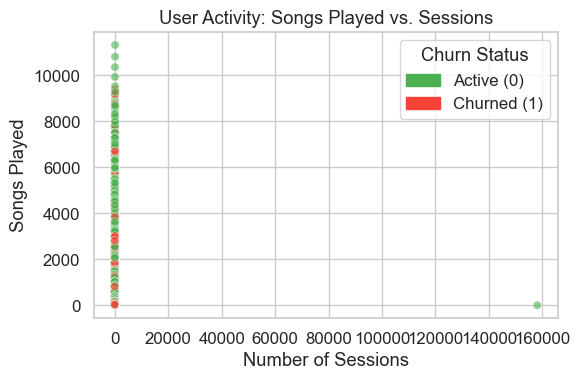

In [40]:
activity = spark.sql("""
    SELECT 
        userId,
        churn_flag,
        COUNT(DISTINCT sessionId) AS num_sessions,
        SUM(CASE WHEN page = 'NextSong' THEN 1 ELSE 0 END) AS songs_played
    FROM user_data
    GROUP BY userId, churn_flag
""").toPandas()

churn_palette = {0: "#4CAF50", 1: "#F44336"}

plt.figure(figsize=(6,4))
scatter = sns.scatterplot(
    data=activity,
    x="num_sessions",
    y="songs_played",
    hue="churn_flag",
    alpha=0.6,
    palette=churn_palette
)
plt.title("User Activity: Songs Played vs. Sessions")
plt.xlabel("Number of Sessions")
plt.ylabel("Songs Played")


legend_handles = [
    Patch(color="#4CAF50", label="Active (0)"),
    Patch(color="#F44336", label="Churned (1)")
]
plt.legend(handles=legend_handles, title="Churn Status")
plt.tight_layout()
plt.show()

Not including extreme values:

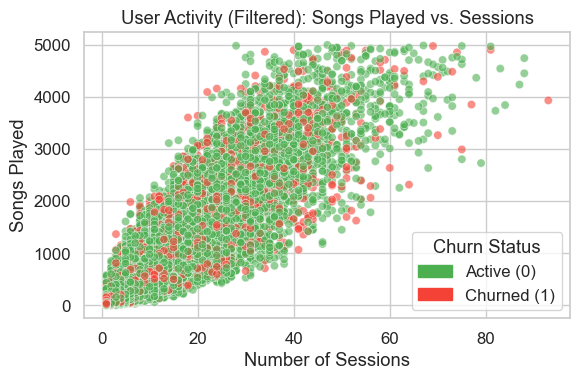

In [41]:
filtered = activity[(activity["num_sessions"] < 500) & (activity["songs_played"] < 5000)]

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=filtered,
    x="num_sessions", y="songs_played",
    hue="churn_flag",
    alpha=0.6,
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("User Activity (Filtered): Songs Played vs. Sessions")
plt.xlabel("Number of Sessions")
plt.ylabel("Songs Played")
legend_handles = [
    Patch(color="#4CAF50", label="Active (0)"),
    Patch(color="#F44336", label="Churned (1)")
]
plt.legend(handles=legend_handles, title="Churn Status")
plt.tight_layout()
plt.show()

User with id = 1261737 never listened to any songs and never went outside of non-musical listening app options. This can explain why this user has so many sessions and 0 songs played. It makes perfect sense to drop this user.

In [42]:
activity[activity["num_sessions"] > 5000]

,userId,churn_flag,num_sessions,songs_played
11458,1261737,0,158115,0


In [43]:
spark.sql("""
    SELECT distinct page
    FROM user_data
    WHERE userId = 1261737
""").show(truncate=False)

+-------------------+
|page               |
+-------------------+
|About              |
|Home               |
|Error              |
|Login              |
|Help               |
|Submit Registration|
|Register           |
+-------------------+



Let's check users who had a few sessions in the app:

In [44]:
activity[activity["num_sessions"] < 3].sort_values("songs_played", ascending=True)


,userId,churn_flag,num_sessions,songs_played
19532,1341146,0,1,0
20352,1586608,0,1,0
17707,1755851,0,1,0
21279,1176703,0,1,0
21342,1673981,0,1,0
...,...,...,...,...
19122,1221432,0,2,717
11992,1334667,0,2,719
19149,1379420,0,2,727
12342,1483106,0,2,815


To focus on behavioral churn prediction, it’s important to exclude users who never meaningfully interacted with the platform.
These users typically represent short-term signups or test accounts that never engaged with any content.

I am applying the following filtering criteria:

* Keep users with at least 3 sessions and at least 1 song played
* Remove users with fewer than 3 sessions and 0 songs played

In total, 16 users met the exclusion criteria and will be removed from the dataset.

In [45]:
activity[(activity["num_sessions"] < 3) & (activity["songs_played"] == 0)].sort_values("songs_played", ascending=True)

,userId,churn_flag,num_sessions,songs_played
775,1793623,0,1,0
17707,1755851,0,1,0
17767,1375496,0,1,0
18373,1267517,0,1,0
18722,1846408,0,1,0
18944,1135477,0,1,0
19532,1341146,0,1,0
20352,1586608,0,1,0
20769,1163202,1,1,0
21279,1176703,0,1,0


In [60]:
activity[(activity["num_sessions"] < 3) & (activity["songs_played"] == 0)].shape[0]

16

In [68]:
exclude_ids = activity[(activity["num_sessions"] < 3) & (activity["songs_played"] == 0)]["userId"].drop_duplicates().tolist()
exclude_ids

['1793623',
 '1755851',
 '1375496',
 '1267517',
 '1846408',
 '1135477',
 '1341146',
 '1586608',
 '1163202',
 '1176703',
 '1438489',
 '1673981',
 '1145574',
 '1689121',
 '1434698',
 '1275139']

In [62]:
len(exclude_ids)

16

In [ ]:
exclude_ids.append("1261737")
exclude_ids = list(set(exclude_ids))

print(f"Total excluded IDs: {len(exclude_ids)}")
print(exclude_ids)

Total excluded IDs: 17
['1673981', '1267517', '1755851', '1689121', '1176703', '1434698', '1261737', '1275139', '1586608', '1375496', '1163202', '1145574', '1341146', '1793623', '1846408', '1135477', '1438489']


In [72]:
data_cleaned = data.filter(~F.col("userId").isin(exclude_ids))

print(f"Original rows: {data.count():,}")
print(f"After cleaning: {data_cleaned.count():,}")

Original rows: 26,259,199


After cleaning: 25,480,697


In [73]:
data_cleaned.write.mode("overwrite").parquet("../data/churn_data_ready.parquet")

### VI. Feature correlations (behavior vs churn)

Users who stay tend to interact more frequently and positively with the content. Lower engagement across these metrics is an early signal of potential churn.

In [89]:
data = spark.read.parquet("../data/churn_data_ready.parquet")

In [90]:
spark.sql("""
    CREATE OR REPLACE TEMP VIEW interactions AS
    SELECT
        userId,
        churn_flag,
        SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) AS thumbs_up,
        SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) AS thumbs_down,
        SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END) AS add_playlist
    FROM user_data
    GROUP BY userId, churn_flag
""")

DataFrame[]

In [91]:
spark.sql("""
    SELECT
        churn_flag,
        AVG(thumbs_up) AS avg_thumbs_up,
        AVG(thumbs_down) AS avg_thumbs_down,
        AVG(add_playlist) AS avg_add_playlist
    FROM interactions
    GROUP BY churn_flag
""").show()

+----------+------------------+------------------+------------------+
|churn_flag|     avg_thumbs_up|   avg_thumbs_down|  avg_add_playlist|
+----------+------------------+------------------+------------------+
|         1|44.867479512292626|11.124525284829103| 24.91625024985009|
|         0| 53.66095513748191|10.625528219971056|27.395947901591896|
+----------+------------------+------------------+------------------+



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


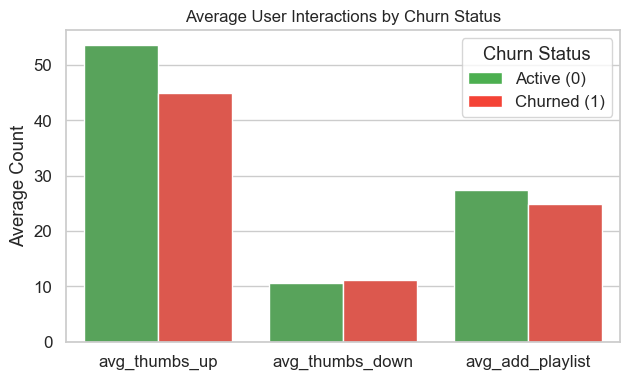

In [97]:
interactions_pd = spark.sql("""
    SELECT churn_flag,
           AVG(thumbs_up) AS avg_thumbs_up,
           AVG(thumbs_down) AS avg_thumbs_down,
           AVG(add_playlist) AS avg_add_playlist
    FROM interactions
    GROUP BY churn_flag
""").toPandas()

interactions_melted = interactions_pd.melt(
    id_vars="churn_flag", var_name="Interaction Type", value_name="Average Count"
)


plt.figure(figsize=(6.5,4))
barplot = sns.barplot(
    data=interactions_melted,
    x="Interaction Type", y="Average Count", hue="churn_flag",
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Average User Interactions by Churn Status", fontsize=12)
plt.xlabel("")
plt.ylabel("Average Count")


legend_elements = [
    Patch(facecolor="#4CAF50", label="Active (0)"),
    Patch(facecolor="#F44336", label="Churned (1)")
]
plt.legend(handles=legend_elements, title="Churn Status")
plt.tight_layout()
plt.show()

### VII. Engagement duration

These metrics below capture how actively and meaningfully users interact with the app, revealing early warning signs of churn. High-engagement users usually stay longer, while those with limited or declining activity patterns are more at risk of cancellation.

In [105]:
data.createOrReplaceTempView("user_data")

engagement_df = spark.sql("""
    SELECT
        userId,
        churn_flag,
        COUNT(DISTINCT sessionId) AS num_sessions,
        SUM(CASE WHEN page = 'NextSong' THEN 1 ELSE 0 END) AS num_songs,
        SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) AS thumbs_up,
        SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) AS thumbs_down,
        SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END) AS add_playlist,
        (MAX(ts) - MIN(ts)) AS active_span_ms,
        (MAX(ts) - MIN(ts)) / (1000 * 60 * 60 * 24) AS active_days
    FROM user_data
    GROUP BY userId, churn_flag
""")
engagement_pdf = engagement_df.toPandas()
engagement_pdf.head()

,userId,churn_flag,num_sessions,num_songs,thumbs_up,thumbs_down,add_playlist,active_span_ms,active_days
0,1190352,0,26,2216,113,28,63,4933696000,57.102963
1,1633577,0,46,3436,181,34,85,5217948000,60.392917
2,1275936,0,52,5968,273,53,171,5261440000,60.896296
3,1735417,0,16,1679,93,23,50,4269771000,49.418646
4,1969795,0,10,966,42,7,28,4288132000,49.631157


In [110]:
engagement_df.createOrReplaceTempView("engagement")

spark.sql("""
    SELECT
        churn_flag,
        ROUND(AVG(num_sessions), 2) AS avg_num_sessions,
        ROUND(AVG(num_songs), 2) AS avg_num_songs,
        ROUND(AVG(thumbs_up), 2) AS avg_thumbs_up,
        ROUND(AVG(thumbs_down), 2) AS avg_thumbs_down,
        ROUND(AVG(add_playlist), 2) AS avg_add_playlist,
        ROUND(AVG(active_days), 2) AS avg_active_days
    FROM engagement
    GROUP BY churn_flag
    ORDER BY churn_flag
""").show(truncate=False)

+----------+----------------+-------------+-------------+---------------+----------------+---------------+
|churn_flag|avg_num_sessions|avg_num_songs|avg_thumbs_up|avg_thumbs_down|avg_add_playlist|avg_active_days|
+----------+----------------+-------------+-------------+---------------+----------------+---------------+
|0         |13.65           |953.94       |53.71        |10.64          |27.42           |45.81          |
|1         |12.3            |876.9        |44.88        |11.13          |24.92           |24.35          |
+----------+----------------+-------------+-------------+---------------+----------------+---------------+



On the plots below, all engagement features are heavily right-skewed, showing that most users are low-activity while a few are extremely active.
The largest behavioral gap between churned and active users appears in active_days, followed by sessions and songs played. Overall, these plots confirm that sustained activity and higher engagement breadth (songs, playlists, thumbs-up) are strong retention indicators.

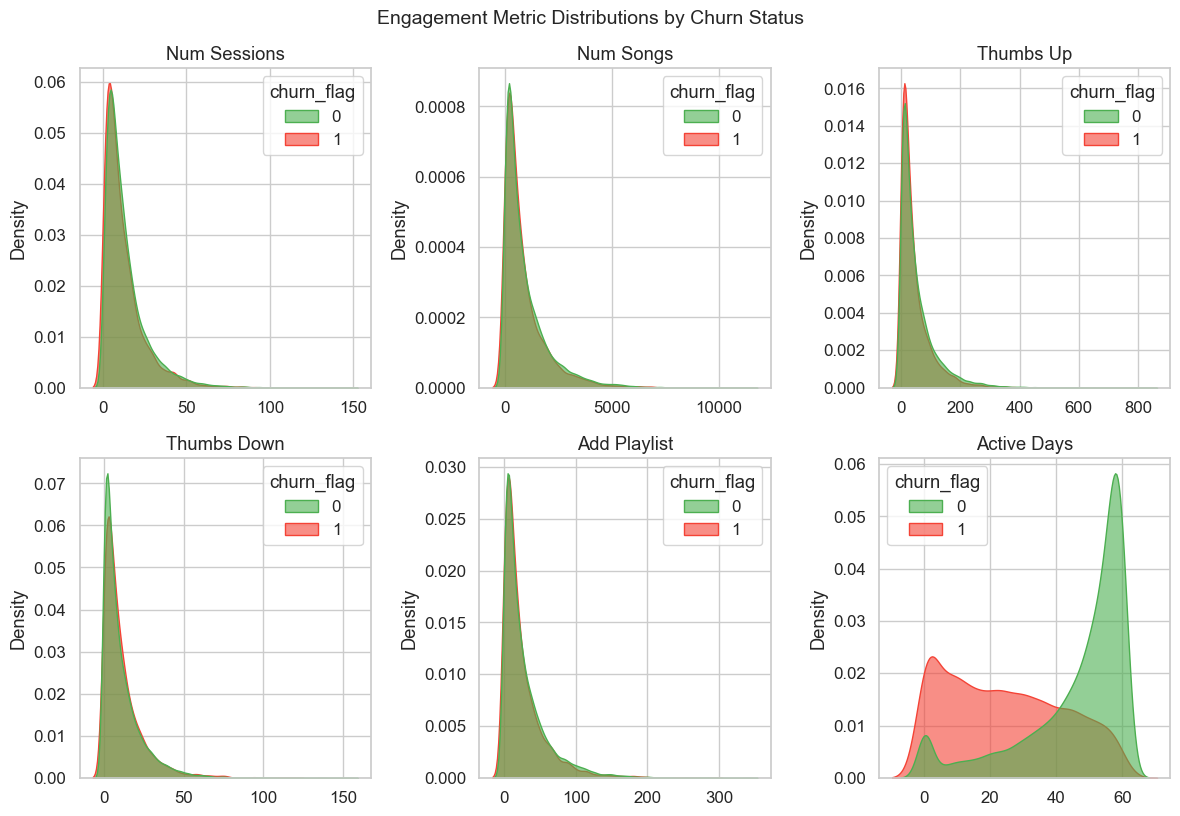

In [115]:
engagement_pd = engagement_df.toPandas()

features = ["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(
        data=engagement_pd,
        x=col,
        hue="churn_flag",
        fill=True,
        common_norm=False,
        palette=["#4CAF50", "#F44336"],
        alpha=0.6
    )
    plt.title(col.replace("_", " ").title())
    plt.xlabel("")
    plt.ylabel("Density")

plt.tight_layout()
plt.suptitle("Engagement Metric Distributions by Churn Status", fontsize=14, y=1.02)
plt.show()

Boxplots below compare user engagement behaviors between active and churned users across six key activity metrics.

The log scale on the y-axis is used to make the data more interpretable, because the raw values are extremely skewed (as we seen above, some users have thousands of sessions or songs, while others have just a few). The log transformation compresses large values and expands small ones, allowing meaningful visual comparison across very different ranges.


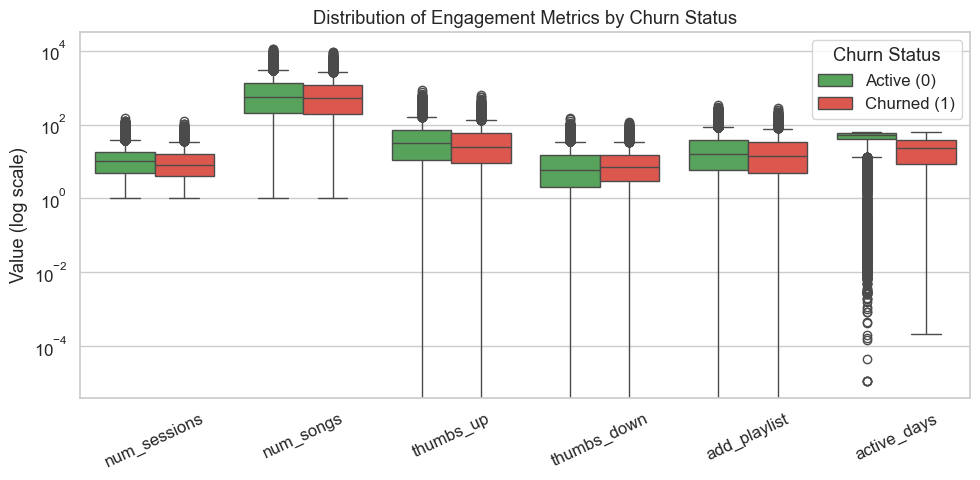

In [ ]:
engagement_pd = engagement_df.toPandas()

engagement_melted = engagement_pd.melt(
    id_vars="churn_flag",
    value_vars=["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"],
    var_name="Metric",
    value_name="Value"
)


plt.figure(figsize=(10,5))
box = sns.boxplot(
    data=engagement_melted,
    x="Metric", y="Value", hue="churn_flag",
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Distribution of Engagement Metrics by Churn Status")
plt.xlabel("")
plt.ylabel("Value (log scale)")
plt.yscale("log")  # helps handle skewed distributions

handles, _ = box.get_legend_handles_labels()
plt.legend(handles, ["Active (0)", "Churned (1)"], title="Churn Status")

plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

We can already see clear behavioral differences — churned users tend to have fewer sessions, fewer songs played, and shorter active periods.

Final correlation analysis and plot of churn factors that can affect retention decisions:

In [116]:
# Correlation between engagement metrics and churn flag
corr = engagement_pdf.corr(numeric_only=True)["churn_flag"].sort_values(ascending=False)
corr

churn_flag        1.000000
thumbs_down       0.016255
num_songs        -0.029237
add_playlist     -0.032534
num_sessions     -0.043034
thumbs_up        -0.057082
active_days      -0.474938
active_span_ms   -0.474938
Name: churn_flag, dtype: float64

This plot is another visualization showing which variables most strongly affect churn.
It illustrates the correlation between each engagement metric and the churn flag — highlighting which behaviors are most predictive of user retention or dropout.

The duration of engagement (active days) is the strongest behavioral signal distinguishing churned from retained users.
Users who remain active for longer periods are consistently less likely to leave, making engagement duration a critical factor for churn prediction and retention strategy design.

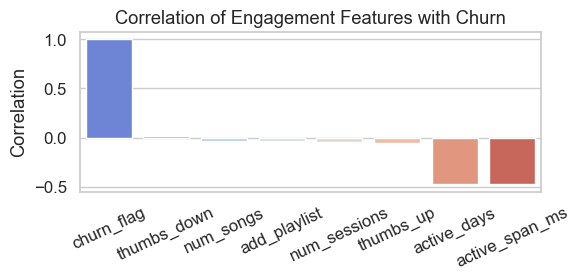

In [ ]:
plt.figure(figsize=(6, 3))
sns.barplot(
    x=corr.index,
    y=corr.values,
    hue=corr.index,          
    palette="coolwarm",
    legend=False           
)
plt.title("Correlation of Engagement Features with Churn")
plt.xlabel(None)
plt.ylabel("Correlation")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### IX. Event Type Exploration

In this section, I want to explore user interactions — represented by the `page` variable.  
Each event corresponds to a specific user action such as playing a song, giving a thumbs up, or canceling their subscription.

We’ll first examine which event types dominate overall, and then compare their distribution between **active** and **churned** users.

#### 1. Count events by type

In [119]:
event_counts = (
    data.groupBy("page")
        .count()
        .orderBy(F.desc("count"))
        .toPandas()
)

event_counts

,page,count
0,NextSong,20850272
1,Thumbs Up,1151465
2,Home,933108
3,Add to Playlist,597921
4,Roll Advert,385212
5,Add Friend,381664
6,Logout,296004
7,Thumbs Down,239212
8,Downgrade,184240
9,Settings,147072


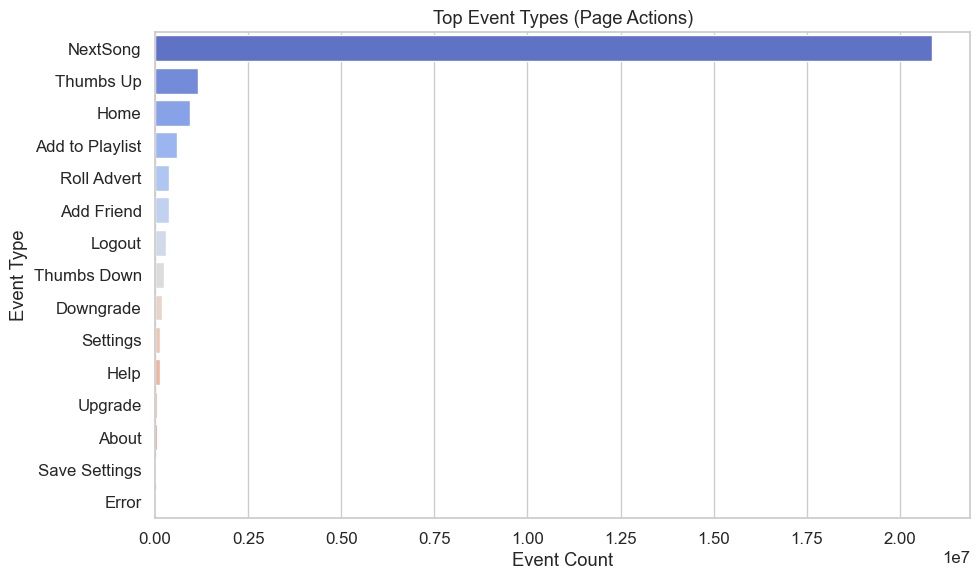

In [121]:
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

sns.barplot(
    data=event_counts.head(15),
    y="page",
    x="count",
    hue="page",           # use y variable for coloring
    palette="coolwarm",
    legend=False          # hide redundant legend
)

plt.title("Top Event Types (Page Actions)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

#### 2. Compare event patterns by churn status

The chart shows that “NextSong” dominates activity across all users, as it represents the main listening behavior. However, active users (green) have far higher counts, meaning they spend more time streaming and engaging with content, while churned users (red) drop off earlier and play fewer songs overall.

Engagement-driven actions such as “Thumbs Up,” “Add to Playlist,” and “Add Friend” occur more frequently among active users, indicating that users who interact beyond just listening are more likely to stay on the platform.

Meanwhile, neutral or transactional actions — like “Logout,” “Downgrade,” and “Thumbs Down” — appear at similar levels across both groups, suggesting that churn results more from reduced engagement than from direct dissatisfaction.

Finally, navigation-related events like “Home” and “Settings” are more common among active users, reflecting their broader and more consistent interaction with the app.

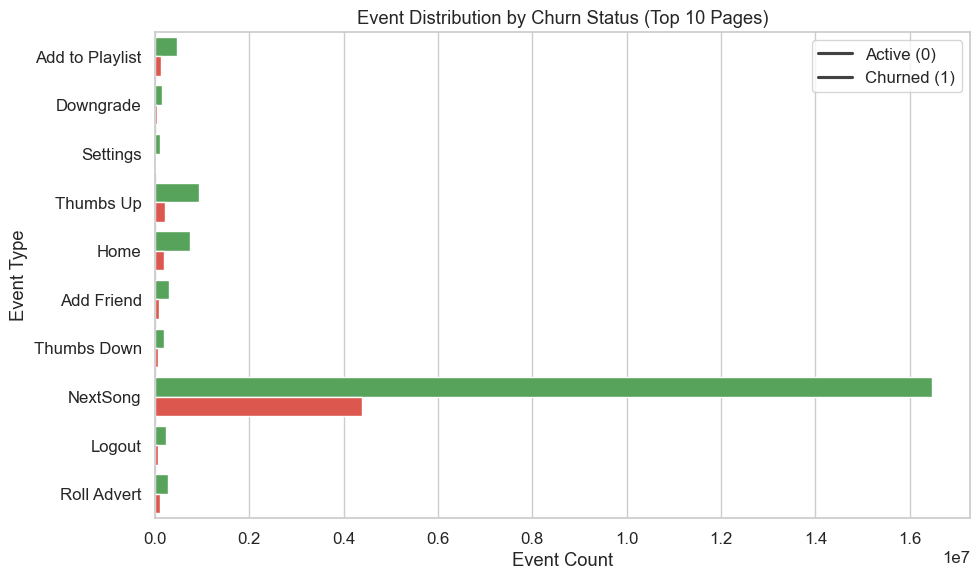

In [122]:
event_by_churn = (
    data.groupBy("page", "churn_flag")
        .count()
        .toPandas()
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=event_by_churn[event_by_churn["page"].isin(event_counts.head(10)["page"])],
    x="count", y="page", hue="churn_flag",
    palette={0: "#4CAF50", 1: "#F44336"}
)
plt.title("Event Distribution by Churn Status (Top 10 Pages)")
plt.xlabel("Event Count")
plt.ylabel("Event Type")
plt.legend(["Active (0)", "Churned (1)"])
plt.tight_layout()
plt.show()

Among the other events (like Thumbs Up and Down, Next Song, and Add to Playlist activities), we can see that the “Roll Advert” event represents moments when a user was served an advertisement while using the app—typically between songs.
 
This event occurs only for free-tier users, since premium subscribers enjoy an ad-free experience. Including it in the analysis helps distinguish free vs. paid users and can provide insights into churn behavior, as users who frequently encounter ads may be more likely to leave the platform or consider upgrading to a paid plan.

#### 3. Normalize event proportions

The plot above shows that events with high overall frequency (like "NextSong") can dominate the analysis simply because they occur often — not necessarily because they’re related to churn.

By normalizing, we shift the focus from: **“How often does this happen overall?”** to **“How much more likely is this event to occur among churned users compared to active ones?”**

This adjustment helps reveal behavioral patterns that truly distinguish churned users from retained ones, rather than just reflecting general platform activity.

In [124]:
event_share = (
    data.groupBy("churn_flag", "page")
        .count()
        .groupBy("page")
        .pivot("churn_flag")
        .sum("count")
        .fillna(0)
        .toPandas()
)

event_share.columns = event_share.columns.astype(str)

for col in ["0", "1"]:
    if col not in event_share.columns:
        event_share[col] = 0

event_share["total"] = event_share["0"] + event_share["1"]
event_share["share_churned"] = event_share["1"] / event_share["total"].replace(0, np.nan) * 100
event_share = event_share.sort_values("share_churned", ascending=False).reset_index(drop=True)

event_share.head(10)

,page,0,1,total,share_churned
0,Cancel,0,5002,5002,100.000000
1,Cancellation Confirmation,0,5002,5002,100.000000
2,Roll Advert,284906,100306,385212,26.039168
3,Submit Upgrade,11448,3687,15135,24.360753
4,Downgrade,140816,43424,184240,23.569257
5,Thumbs Down,183556,55656,239212,23.266391
6,Submit Downgrade,4992,1502,6494,23.129042
7,Upgrade,39276,11231,50507,22.236522
8,Settings,115357,31715,147072,21.564268
9,Error,19718,5330,25048,21.279144


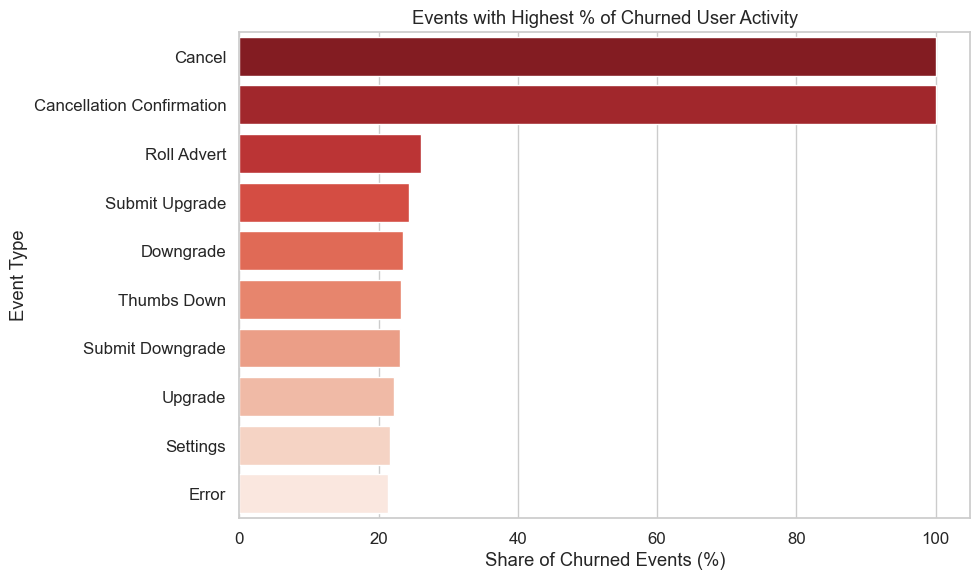

In [126]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=event_share.head(10),
    x="share_churned",
    y="page",
    hue="page",             # assign hue to the same variable as y
    palette="Reds_r",
    legend=False            # suppress redundant legend
)
plt.title("Events with Highest % of Churned User Activity")
plt.xlabel("Share of Churned Events (%)")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()

Understanding the Difference: `Cancel` vs `Cancellation Confirmation`

In the dataset, the **`page`** column records every user action (event) on the platform.  
Two of these events — `Cancel` and `Cancellation Confirmation` — are closely related but have very different meanings:

| Page Event | Description | Indicates |
|-------------|-------------|------------|
| **Cancel** | The user *clicked on the "Cancel" button* to start the cancellation process. Some users may explore this option without actually completing it. | 🟡 *Intent to churn* (not a confirmed cancellation) |
| **Cancellation Confirmation** | The user *confirmed their cancellation* — meaning they officially unsubscribed and stopped using the service. | 🔴 *Actual churn* |

Therefore, in churn labeling we consider **only users who reached `Cancellation Confirmation` as churned**.  
This ensures that we capture **real customer attrition**, not just users exploring cancellation options.

> It might be a good idea to check users who clicked on “Cancel” but did not confirm, as they can be analyzed as an “at-risk” group — users showing churn intent but still retained. However, as we’ve previously seen, the counts of “Cancel” and “Cancellation Confirmation” events are identical in our dataset, which can lead to a conclusiong about the same users who firstly click “Cancel” and the received “Cancellation Confirmation” event. 

How many users clicked "Cancel" but did NOT confirm ("at-risk" users)?

In [127]:
users_cancel = data.filter(data.page == "Cancel").select("userId").distinct()
users_canceled = data.filter(data.page == "Cancellation Confirmation").select("userId").distinct()
users_at_risk = users_cancel.subtract(users_canceled)

num_at_risk = users_at_risk.count()
print(f"Number of users who clicked 'Cancel' but did not confirm (at-risk): {num_at_risk}")

Number of users who clicked 'Cancel' but did not confirm (at-risk): 0


All users who triggered “Cancellation Confirmation” have definitively left the app. This confirms that, at least in this dataset, we don’t have an “at-risk” group. Still, it’s always good practice to check for this group during EDA before modeling.

#### 4. Monthly Churn and Activity Trends

There are 3 periods from the same year represented in the data: September 2018, October 2018, and November 2018.

In [133]:
data.createOrReplaceTempView("data")
spark.sql("""
    SELECT DISTINCT month, year
    FROM data
    ORDER BY year, month
""").show()

+-----+----+
|month|year|
+-----+----+
|    9|2018|
|   10|2018|
|   11|2018|
+-----+----+



Here, we can clearly see which of the three periods had the highest retention percentage.

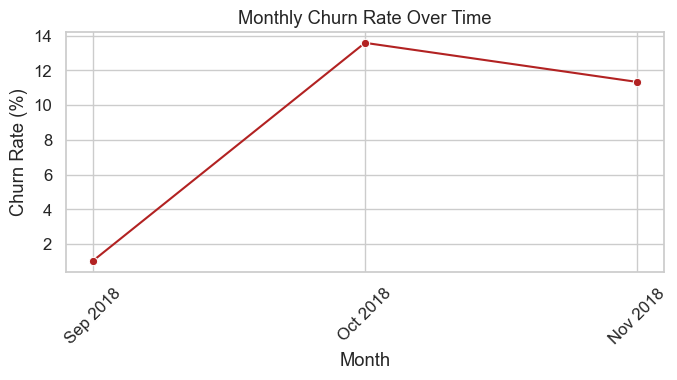

In [138]:
data_month = data.withColumn("event_month", F.date_trunc("month", F.from_unixtime(F.col("ts") / 1000)))

active = (data_month.filter(F.col("userId") != "")
          .select("userId", "event_month").distinct()
          .groupBy("event_month").agg(F.countDistinct("userId").alias("active_users")))

churned = (data_month.filter(F.col("page") == "Cancellation Confirmation")
           .select("userId", "event_month").distinct()
           .groupBy("event_month").agg(F.countDistinct("userId").alias("churned_users")))

trend = (active.join(churned, "event_month", "left")
         .fillna({"churned_users": 0})
         .withColumn("churn_rate", F.col("churned_users") / F.col("active_users"))
         .orderBy("event_month"))


trend_pd = trend.toPandas()
trend_pd["month"] = pd.to_datetime(trend_pd["event_month"]).dt.strftime("%b %Y")

plt.figure(figsize=(7,4))
sns.lineplot(data=trend_pd, x="month", y=trend_pd["churn_rate"]*100, marker="o", color="firebrick")
plt.title("Monthly Churn Rate Over Time")
plt.xlabel("Month"); plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### X. Correlations (Feature vs Churn)

To understand which user behaviors are most strongly associated with churn,  
we examine correlations between engagement features (sessions, songs, likes, etc.) and the churn flag.

This helps identify which features are likely to be **predictive** and will inform our modeling phase.

In [140]:
engagement_pdf = engagement_df.toPandas()

In [141]:
engagement_df = (
    data.groupBy("userId", "churn_flag")
        .agg(
            F.countDistinct("sessionId").alias("num_sessions"),
            F.count(F.when(F.col("page") == "NextSong", True)).alias("num_songs"),
            F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("thumbs_up"),
            F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("thumbs_down"),
            F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("add_playlist"),
            (F.max("ts") - F.min("ts")).alias("active_span_ms")
        )
        .withColumn("active_days", (F.col("active_span_ms") / (1000 * 60 * 60 * 24)))
)
engagement_pdf = engagement_df.toPandas()

In [142]:
corr = engagement_pdf.corr(numeric_only=True).round(3)
corr["churn_flag"].sort_values(ascending=False)

churn_flag        1.000
thumbs_down       0.016
num_songs        -0.029
add_playlist     -0.033
num_sessions     -0.043
thumbs_up        -0.057
active_span_ms   -0.475
active_days      -0.475
Name: churn_flag, dtype: float64

Correlation heatmap shows the same results we confirmed above in Section VII. Engagement duration

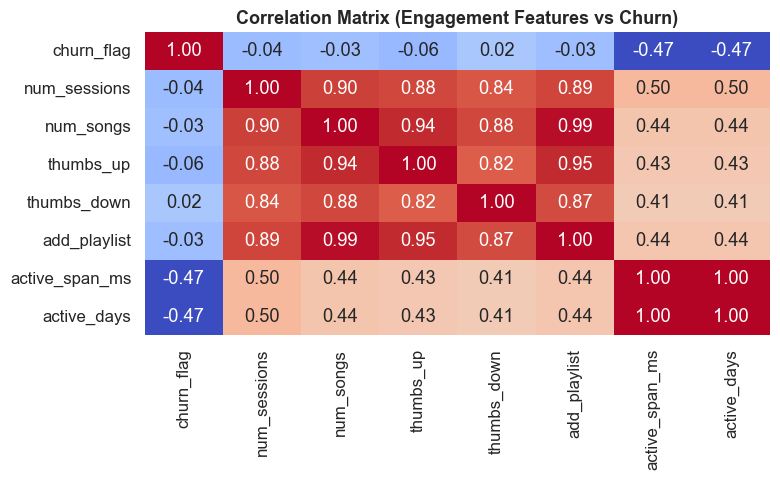

In [143]:
sns.set(style="white", font_scale=1.1)
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title("Correlation Matrix (Engagement Features vs Churn)", fontsize=13, weight="semibold")
plt.tight_layout()
plt.show()

### XI. Geographic Insights

The `location` field combines city and state information (e.g., *"San Francisco-Oakland-Hayward, CA"*). And I already brekaed it two additonal columns `state` and `city`.

In this section, we analyze churn patterns by location to see whether certain regions have higher churn or engagement levels.
While geographic data is often only a proxy (e.g., time zones, demographics, or marketing coverage), it can still provide valuable insights for targeted retention strategies.

In [145]:
data.createOrReplaceTempView("data")
spark.sql("""
    SELECT state, COUNT(*) as count
    FROM (
        SELECT DISTINCT state, userId
        FROM data
        WHERE state IS NOT NULL
    )
    GROUP BY state
    ORDER BY count DESC
""").toPandas()

,state,count
0,CA,2803
1,TX,1814
2,NY-NJ-PA,1567
3,FL,1423
4,OH,703
...,...,...
95,MI-WI,4
96,MS-LA,4
97,ID-WA,4
98,WY-ID,4


This dataset includes user location fields from event logs (like “city, state” or “city, states”), and it likely comes from the user’s IP geolocation or a standardized MSA-level location mapping. Platforms (like Spotify, Census data, or city-level aggregators) often use MSA names to better represent broader urban areas rather than just one city or state.

For these kinds of locations, I’m going to use only the first state that appears.

In [149]:
data.filter(F.col("state") == "IL-IN-WI").toPandas().head(5)

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,status,ts,userAgent,churn_flag,state,city,datetime,date,month,year
0,1716700,British Sea Power,Logged In,Kyla,F,94,Adams,218.85342,paid,"Chicago-Naperville-Elgin, IL-IN-WI",...,200,1542997916000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",0,IL-IN-WI,Chicago-Naperville-Elgin,2018-11-23 10:31:56,2018-11-23,11,2018
1,1716700,Lady & Bird,Logged In,Kyla,F,95,Adams,255.32036,paid,"Chicago-Naperville-Elgin, IL-IN-WI",...,200,1542998134000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",0,IL-IN-WI,Chicago-Naperville-Elgin,2018-11-23 10:35:34,2018-11-23,11,2018
2,1716700,Penguin CafÃÂ© Orchestra,Logged In,Kyla,F,96,Adams,270.31465,paid,"Chicago-Naperville-Elgin, IL-IN-WI",...,200,1542998389000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",0,IL-IN-WI,Chicago-Naperville-Elgin,2018-11-23 10:39:49,2018-11-23,11,2018
3,1716700,The Smiths,Logged In,Kyla,F,97,Adams,144.61342,paid,"Chicago-Naperville-Elgin, IL-IN-WI",...,200,1542998659000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",0,IL-IN-WI,Chicago-Naperville-Elgin,2018-11-23 10:44:19,2018-11-23,11,2018
4,1716700,None,Logged In,Kyla,F,98,Adams,NaN,paid,"Chicago-Naperville-Elgin, IL-IN-WI",...,200,1542998659000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",0,IL-IN-WI,Chicago-Naperville-Elgin,2018-11-23 10:44:19,2018-11-23,11,2018


In [ ]:
data = data.withColumn(
    "state",
    F.when(
        F.col("state").contains("-"),
        F.substring_index(F.col("state"), "-", 1)
    ).otherwise(F.col("state"))
)

data = data.withColumn("state", F.upper(F.trim(F.col("state"))))

In [151]:
data.createOrReplaceTempView("data")
spark.sql("""
    SELECT state, COUNT(*) as count
    FROM (
        SELECT DISTINCT state, userId
        FROM data
        WHERE state IS NOT NULL
    )
    GROUP BY state
    ORDER BY count DESC
""").toPandas()

,state,count
0,CA,2803
1,NY,2041
2,TX,1826
3,FL,1423
4,PA,1092
5,OH,929
6,IL,900
7,GA,689
8,MI,674
9,NC,638


The chart shows that most users come from large and populous states, with California, New York, and Texas leading by a wide margin. These states represent the strongest user bases, likely due to higher population density and stronger digital engagement. Florida, Pennsylvania, and Ohio also have notable user activity, suggesting broad national coverage.

Overall, user distribution follows a long-tail pattern — a few states dominate, while the rest contribute smaller but meaningful portions of the total user base. This insight can help prioritize regional marketing and retention efforts.

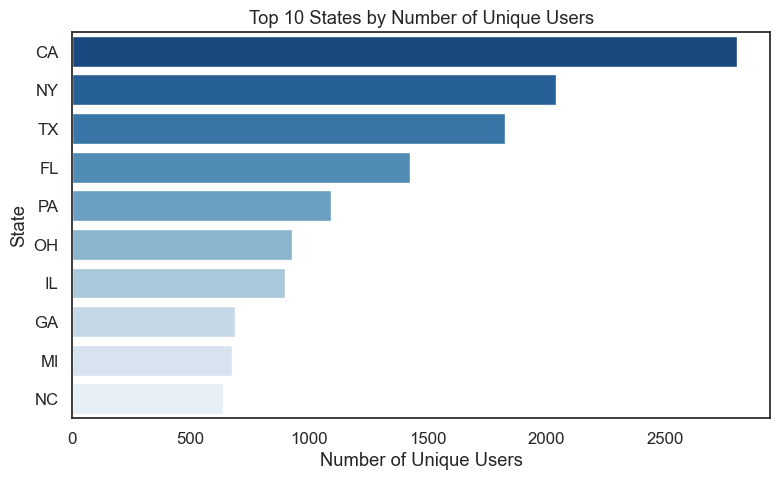

In [ ]:
state_counts = spark.sql("""
    SELECT state, COUNT(*) AS count
    FROM (
        SELECT DISTINCT state, userId
        FROM data
        WHERE state IS NOT NULL
    )
    GROUP BY state
    ORDER BY count DESC
""").toPandas()

plt.figure(figsize=(8,5))
sns.barplot(
    data=state_counts.head(10),
    x="count",
    y="state",
    hue="state",         
    palette="Blues_r",
    legend=False
)
plt.title("Top 10 States by Number of Unique Users")
plt.xlabel("Number of Unique Users")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [153]:
churn_by_state = (
    data.filter(F.col("state").isNotNull())
        .select("userId", "state", "churn_flag")
        .distinct()
        .groupBy("state")
        .agg(
            F.count("*").alias("total_users"),
            F.sum("churn_flag").alias("churned_users")
        )
        .withColumn("churn_rate", (F.col("churned_users") / F.col("total_users")) * 100)
        .orderBy(F.desc("churn_rate"))
        .toPandas()
)

churn_by_state.head(10)

,state,total_users,churned_users,churn_rate
0,SD,52,17,32.692308
1,ME,65,19,29.230769
2,WY,32,9,28.125000
3,WV,126,34,26.984127
4,NH,67,18,26.865672
5,HI,116,31,26.724138
6,DC,455,119,26.153846
7,MO,496,126,25.403226
8,ID,115,29,25.217391
9,WI,335,84,25.074627


The chart shows that South Dakota has the highest churn rate, followed by Maine and Wyoming — all with rates above 25%. Most of the states with high churn are smaller or less populous, suggesting weaker engagement or limited user stickiness in those regions. Coastal and midwestern states like Hawaii, Missouri, and Wisconsin also appear in the top ten but with slightly lower churn rates.

Overall, the pattern indicates that users from smaller or less digitally active markets tend to leave the platform more often. These regions could benefit from targeted retention strategies, such as improving local engagement or offering personalized promotions.

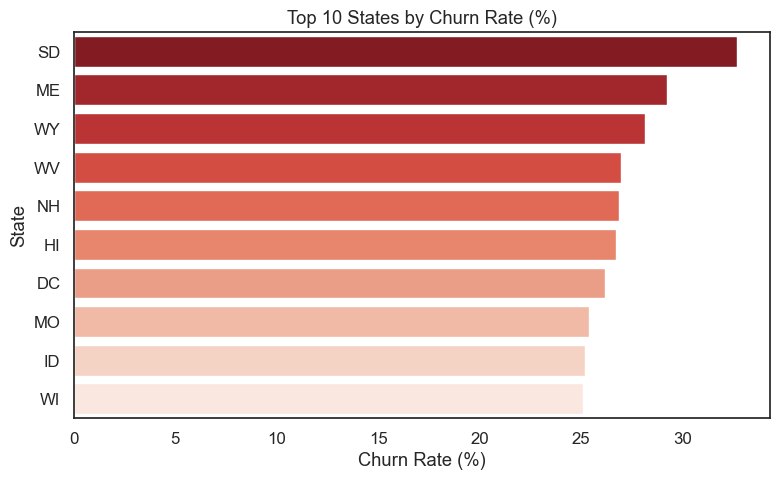

25/10/14 19:37:31 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 925142 ms exceeds timeout 120000 ms
25/10/14 19:37:31 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/14 19:37:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=churn_by_state.head(10),
    x="churn_rate", y="state",
    hue="state",          
    palette="Reds_r",
    legend=False           
)
plt.title("Top 10 States by Churn Rate (%)")
plt.xlabel("Churn Rate (%)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

### Summary:

This exploratory analysis uncovered key behavioral and demographic patterns distinguishing churned from active users.

* Churned users consistently show shorter engagement spans, fewer sessions, and lower interaction levels (fewer songs, likes, and playlists).
* Active_days emerged as the strongest negative correlate with churn, confirming that sustained engagement is the best retention signal.
* Normalized event proportions revealed that churned users are overrepresented in events like “Cancel”, “Downgrade”, and “Roll Advert”, indicating dissatisfaction or reduced interest before leaving.
* Temporal trends showed fluctuations in churn rate across months, while state-level analysis highlighted geographic differences in user retention.
* Overall, the EDA validated the data’s consistency and identified the most relevant behavioral features for churn prediction.

### Next Steps (03_Modeling.ipynb):

* Prepare feature matrix for modeling, ensuring scaling and encoding consistency.
* Train baseline classification models (Logistic Regression, Random Forest, Gradient Boosting).
* Evaluate model performance using ROC-AUC, Precision-Recall, and confusion metrics.
* Identify top predictors of churn and interpret results using feature importance and SHAP analysis.
* Translate model insights into actionable retention strategies for improving customer engagement.